In [14]:
#from FISHPainter.src.datasets import create_dataset
from FISHPainter.src.datasets.create import create_dataset
from FISHPainter.src.utils.utils import print_structure, save2h5
from cellplot.patches import gridPlot
import numpy as np
import h5py

np.random.seed(42)‚

In [15]:
config_file = "./configs/config_template.yml"

dataset = create_dataset(config_file, FISH_type="COPY_NUMBER", verbose=True)

print("\nOverview of dataset dictionary structure")

print_structure(dataset)
save2h5(dataset, "./datasets/example.h5")

Found the following 2 conditions: CONDITION_0, CONDITION_1


Working on CONDITION_0:   8%|▊         | 8/100 [00:00<00:03, 26.12it/s]

Working on CONDITION_1: 100%|██████████| 100/100 [00:04<00:00, 22.69it/s]



Overview of dataset dictionary structure
CONDITION_0
     rgb_patches
     masks
     parameters
     target_classes
CONDITION_1
     rgb_patches
     masks
     parameters
     target_classes


Exception: ./datasets/example.h5 already exists!

Keys in dataset are the following: <KeysViewHDF5 ['classes', 'image_patches', 'mask_patches', 'parameters']>


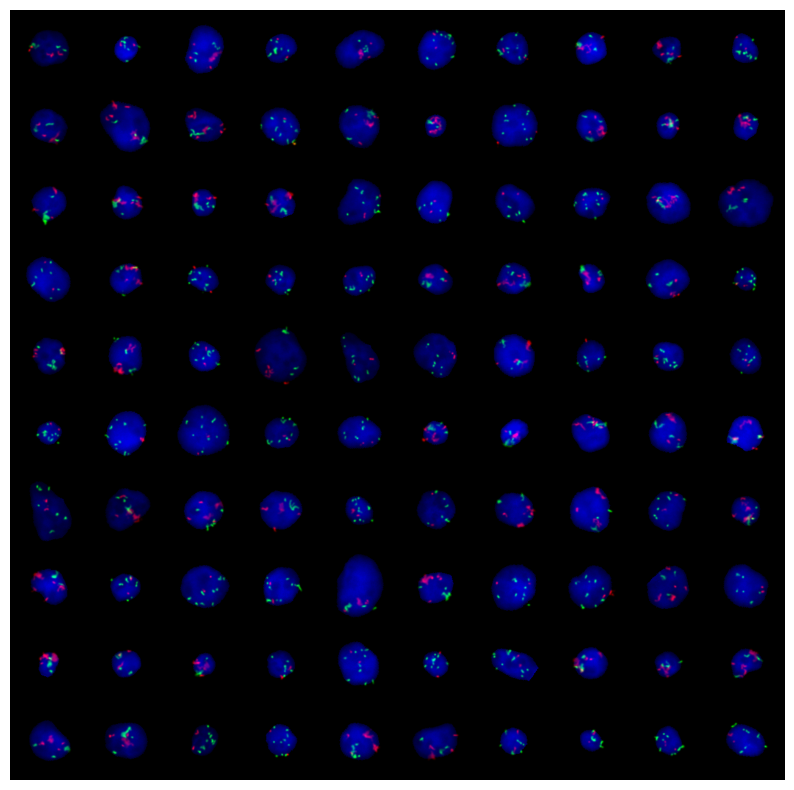

In [16]:
with h5py.File("./datasets/example.h5", 'r') as f:
    
    print(f"Keys in dataset are the following: {f.keys()}")
    
    images = f["image_patches"][()]
    
    idx = np.arange(len(images))
    np.random.shuffle(idx)

    gridPlot(images[idx], vspace=-0.01, hspace=-0.01)